# Deep Learning: Ex.9 - Generative Adversarial Networks (GAN)


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tqdm import tqdm

print(tf.__version__)

2.6.0


---
### Loading the dataset

This dataset contains ~20K anime-face images (each image is 64x64 pixels):

In [2]:
import gdown
from zipfile import ZipFile

url = "https://drive.google.com/uc?id=1LexPQrxAon5gGnXTXSK3pbavZrb4ziRc"
gdown.download(url, 'data.zip', quiet=False)  # ~ 480MB

print('unzipping...')
with ZipFile("data.zip", "r") as zipobj:
    zipobj.extractall()  # unzip the file

print('done.')


Downloading...
From: https://drive.google.com/uc?id=1LexPQrxAon5gGnXTXSK3pbavZrb4ziRc
To: /content/data.zip
100%|██████████| 480M/480M [00:08<00:00, 55.0MB/s]


unzipping...
done.


Found 21551 images belonging to 1 classes.
dataset.shape = (21551, 64, 64, 3)


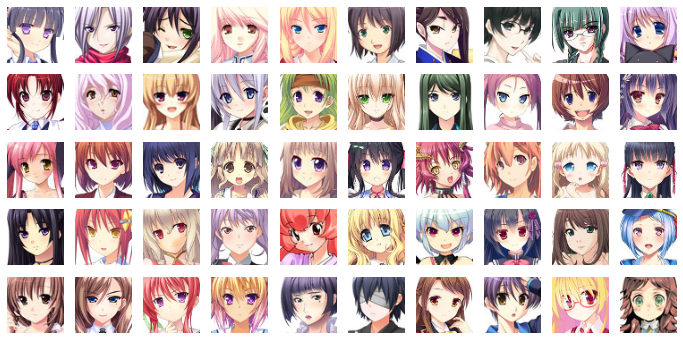

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator(rescale=1./255)

dataset = dataGen.flow_from_directory('anime_data', target_size=(64,64), batch_size=25000, class_mode='sparse').next()[0]
print('dataset.shape =',dataset.shape)

# plot some samples:
plt.figure(figsize=(12,6))
for i in range(50):
		plt.subplot(5, 10, 1 + i)
		plt.axis('off')
		plt.imshow(dataset[i])

***

### 1. Training a GAN model 

- Use our model developed in `class9.ipynb`, and adjust its architecture to match the new dataset images shape: `(64,64,3)`.

- Use a latent dimension of 20-D as the noise input for the generator model.

- Generate 12 noise vectors (each one is of 20-D), and use these vectors to generate 12 images from the (un-trained) generator. Display the images in a single row of sublplots.



In [4]:
###########################
###  your code here...  ###
###########################

# Create the discriminator
D_model = Sequential(name='Discriminator')
D_model.add(Input(shape=(64,64,3)))

D_model.add(Conv2D(32, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
# D_model.add(Dropout(0.4))

D_model.add(Conv2D(64, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
# D_model.add(Dropout(0.4))


D_model.add(Conv2D(128, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))

D_model.add(Flatten())
D_model.add(Dense(1, activation='sigmoid'))


# compile model
opt = Adam(learning_rate=0.0002, beta_1=0.5)
D_model.compile(loss='binary_crossentropy', optimizer=opt)

D_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [5]:
# Create the generator

latent_dim = 20 # dimension of the noise seed 

G_model = Sequential(name='G_model')
G_model.add(Dense(128*16*16, input_dim=latent_dim)) 
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Reshape((16, 16, 128)))

# upsample to 32x32
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

# upsample to 64x64
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

G_model.add(Conv2D(3, (7,7), activation='sigmoid', padding='same'))

G_model.summary()

Model: "G_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             688128    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 128)       0   

In [6]:
# first, make weights in the discriminator not trainable
D_model.trainable = False

# then connect the models:
GAN_model = Sequential(name='GAN_model')
GAN_model.add(G_model) # add the generator
GAN_model.add(D_model) # add the discriminator

# lastly, compile the GAN model:
opt = Adam(learning_rate=0.0002, beta_1=0.5)
GAN_model.compile(loss='binary_crossentropy', optimizer=opt)

GAN_model.summary()

Model: "GAN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_model (Sequential)         (None, 64, 64, 3)         1231491   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 173793    
Total params: 1,405,284
Trainable params: 1,231,491
Non-trainable params: 173,793
_________________________________________________________________


noise.shape = (1, 20)
generated_img.shape = (1, 64, 64, 3)


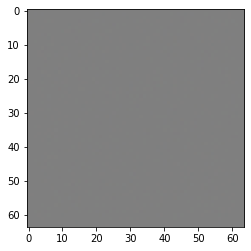

In [10]:
noise_input = np.random.randn(1,latent_dim)
print('noise.shape =',noise_input.shape)
generated_img = G_model.predict(noise_input)
print('generated_img.shape =',generated_img.shape)

plt.imshow(generated_img[0,:,:,:])

plt.show()

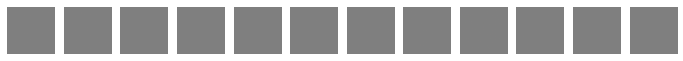

In [8]:
n_examples = 12
examples_input = np.random.randn(n_examples,latent_dim)
examples = G_model.predict(examples_input)
plt.figure(figsize=(n_examples,1))
for i in range(n_examples):
    plt.subplot(1, n_examples, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,:])
plt.show()

- Train the GAN model for 50-100 epochs (it take ~1min/epoch).

- After each and every epoch, feed the **same** 12 noise vectors to the generator, and plot a generated images. This will help you follow the training progress. 


100%|██████████| 168/168 [01:37<00:00,  1.73it/s]


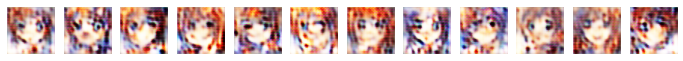

100%|██████████| 168/168 [01:37<00:00,  1.73it/s]


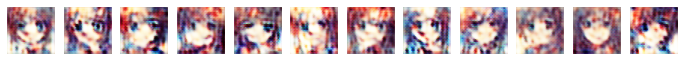

100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


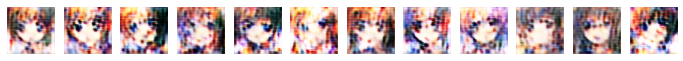

100%|██████████| 168/168 [01:37<00:00,  1.72it/s]


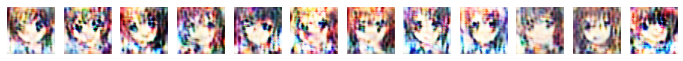

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


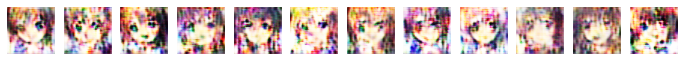

100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


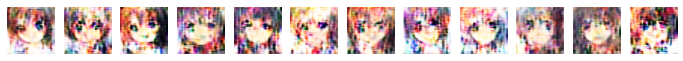

100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


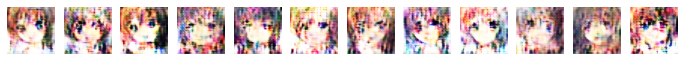

100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


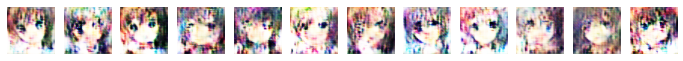

100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


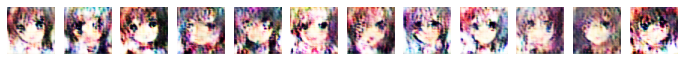

100%|██████████| 168/168 [01:38<00:00,  1.71it/s]


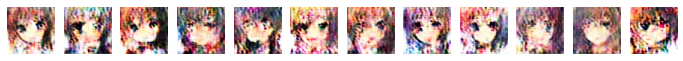

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


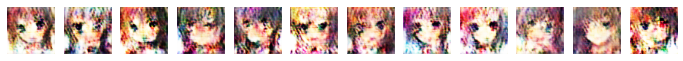

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


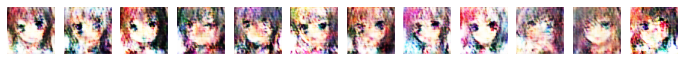

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


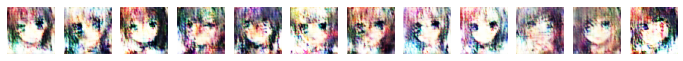

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


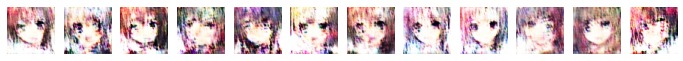

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


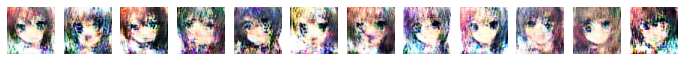

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


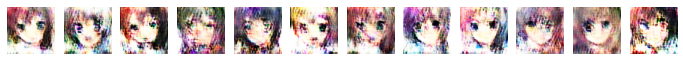

100%|██████████| 168/168 [01:38<00:00,  1.70it/s]


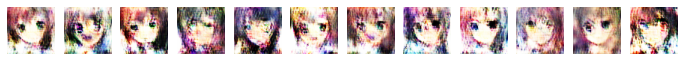

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


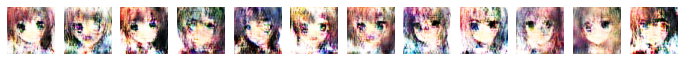

100%|██████████| 168/168 [01:39<00:00,  1.70it/s]


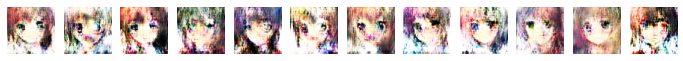

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


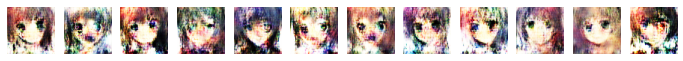

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


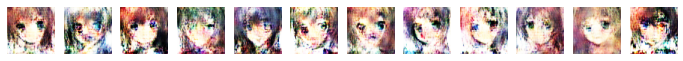

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


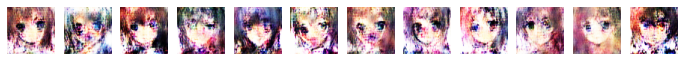

100%|██████████| 168/168 [01:39<00:00,  1.70it/s]


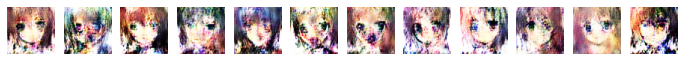

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


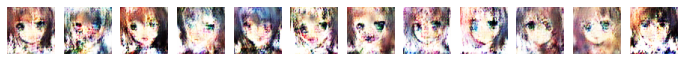

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


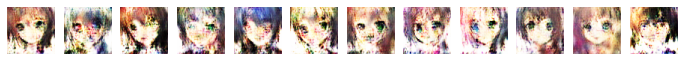

100%|██████████| 168/168 [01:39<00:00,  1.68it/s]


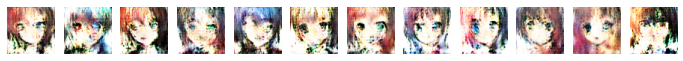

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


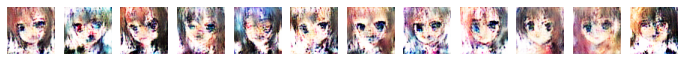

100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


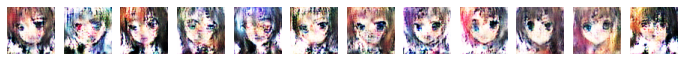

100%|██████████| 168/168 [01:40<00:00,  1.68it/s]


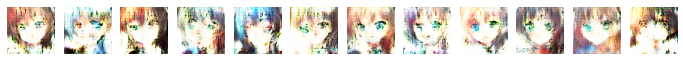

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


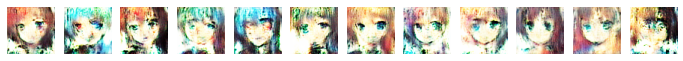

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


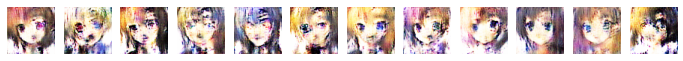

100%|██████████| 168/168 [01:40<00:00,  1.68it/s]


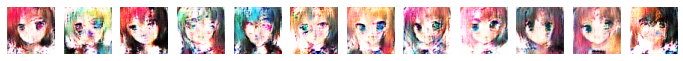

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


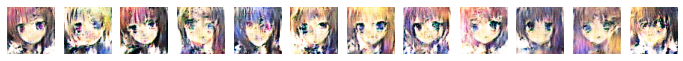

100%|██████████| 168/168 [01:39<00:00,  1.68it/s]


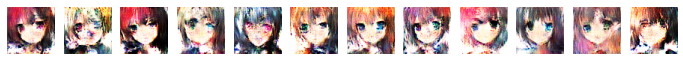

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


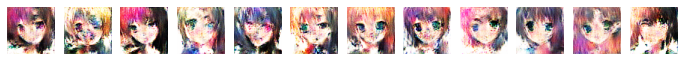

100%|██████████| 168/168 [01:40<00:00,  1.68it/s]


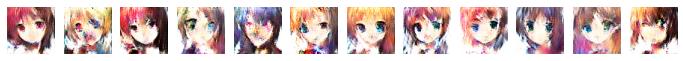

100%|██████████| 168/168 [01:41<00:00,  1.65it/s]


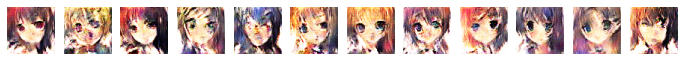

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


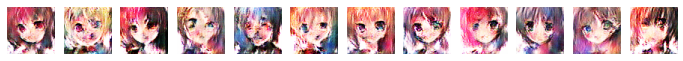

100%|██████████| 168/168 [01:41<00:00,  1.65it/s]


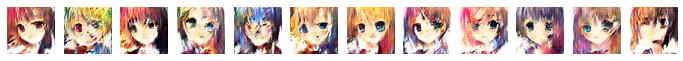

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


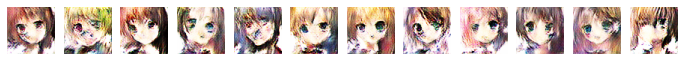

100%|██████████| 168/168 [01:41<00:00,  1.65it/s]


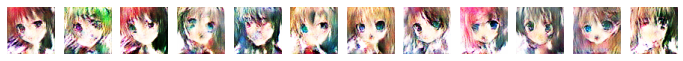

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


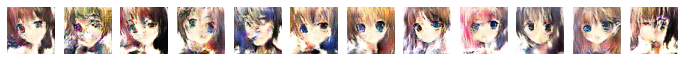

100%|██████████| 168/168 [01:41<00:00,  1.65it/s]


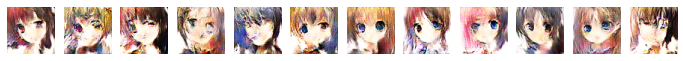

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


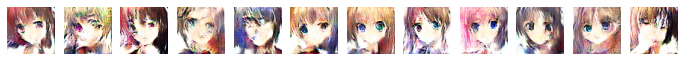

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


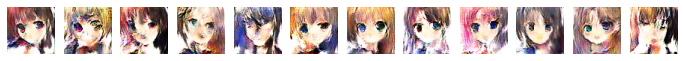

100%|██████████| 168/168 [01:40<00:00,  1.66it/s]


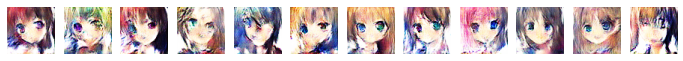

100%|██████████| 168/168 [01:41<00:00,  1.66it/s]


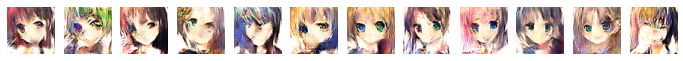

100%|██████████| 168/168 [01:40<00:00,  1.67it/s]


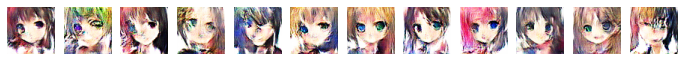

100%|██████████| 168/168 [01:41<00:00,  1.66it/s]


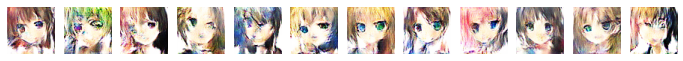

100%|██████████| 168/168 [01:41<00:00,  1.66it/s]


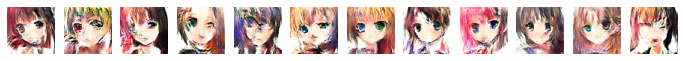

In [ ]:
###########################
###  your code here...  ###
###########################
n_batch = 128
n_epochs = 50
batch_per_epoch = dataset.shape[0] // n_batch


for i in range(n_epochs):
  for j in tqdm(range(batch_per_epoch)):

    # generate 'real' samples
    ix = np.random.randint(0, dataset.shape[0], n_batch)     
    X_real = dataset[ix] # choose random instances
    y_real = np.ones((n_batch, 1)) # 'real' class labels = 1

    # generate 'fake' examples
    noise_input = np.random.randn(n_batch,latent_dim)
    X_fake = G_model.predict(noise_input)
    y_fake = np.zeros((n_batch, 1))  # 'fake' class labels = 0

    # update discriminator model weights
    D_loss_real = D_model.train_on_batch(X_real, y_real)
    D_loss_fake = D_model.train_on_batch(X_fake, y_fake)
    D_loss = (D_loss_real+D_loss_fake) / 2

    # prepare points in latent space as input for the generator
    X_gan = np.random.randn(n_batch,latent_dim)
    y_gan = np.ones((n_batch, 1)) #  labels = 1 (wants discriminator to mistake images as real..)
   
    # update the generator via the discriminator's error
    G_loss = GAN_model.train_on_batch(X_gan, y_gan)

  # summarize loss on this batch
  examples = G_model.predict(examples_input)
  plt.figure(figsize=(n_examples,1))
  for i in range(n_examples):
      plt.subplot(1, n_examples, 1 + i)
      plt.axis('off')
      plt.imshow(examples[i, :, :, :])
  plt.show()


***

### 2. Exploring the latent (input) space

- Generate and display 64 **new** images from the generator (use 8x8 subplots).

- Pick a single "good" image out of these images, and denote the seed-vector that generated it by `z`.

- Next, generate 25 new seed vectors, based on this specific `z`, in the following way:

 - We will add a small-variance noise vector `dz` (a.k.a pertubation, also of 20-D) to `z`, and feed the new vector (`z + dz`) to the generator, to generate a new image. 
  - Use a Normal distribution with $\sigma=0.5$ for the pertubation `dz` (you can experiment with different values for $\sigma$).

- Repeat this process to generate a total of 25 new images (each generated from the same seed `z` but with a different pertubation `dz`).

- Display the results (use 5x5 subplots)






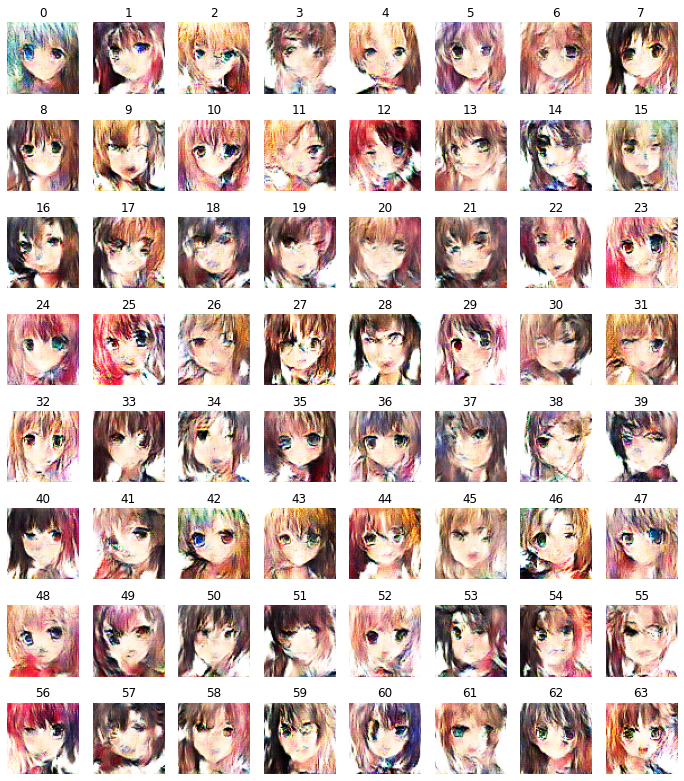

In [ ]:
    ###########################
    ###  your code here...  ###
    ###########################
n = 64
noise_input = np.random.randn(n,latent_dim)
examples = G_model.predict(noise_input)

plt.figure(figsize=(12,14))
for i in range(n):
		plt.subplot(8, 8, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
		plt.title(i)
plt.show()

(20,)
(25, 20)


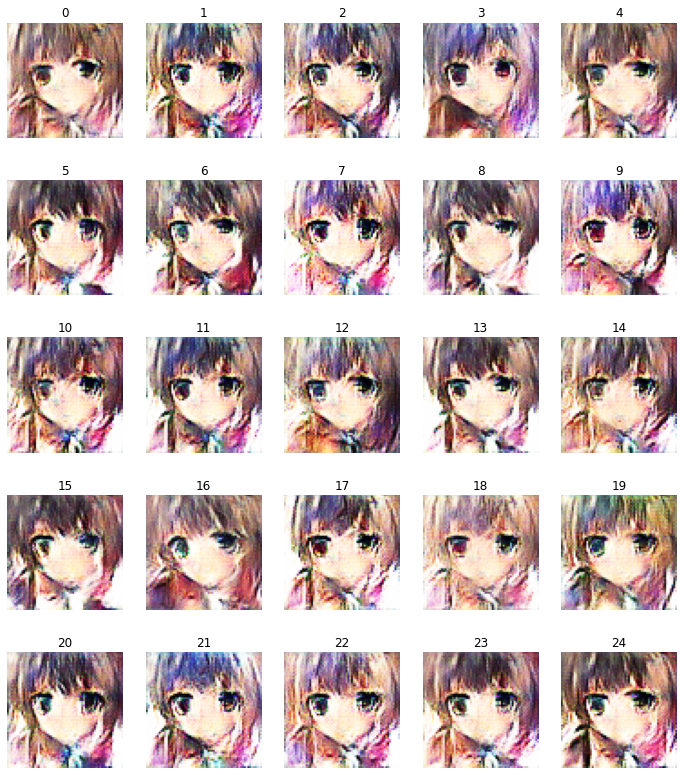

In [ ]:
z = noise_input[36]
print(z.shape)
mean = 0
sigma = 0.5
number_of_samples = 25
new_noise_inputs = (sigma * np.random.randn(number_of_samples,latent_dim) + mean) + z
print(new_noise_inputs.shape)
variations = G_model.predict(new_noise_inputs)

plt.figure(figsize=(12,14))
for i in range(number_of_samples):
		plt.subplot(5, 5, 1 + i)
		plt.axis('off')
		plt.imshow(variations[i, :, :, :])
		plt.title(i)
plt.show()

***
### 3. Morphing between two images


- Pick 2 out of the 64 examples you've generated in Q2. Denote the seed-vectors that generated these images by `z1` and `z2`.

- We will try to "morph" between these two images, by "walking" in the latent space from `z1` to `z2`.

 - Generate a set of 10 seed-vectors, using a linear interpolation (by varying $\alpha$ from 1 to 0):

$$ \vec{z}_{interp} \ \ =\ \  \alpha \cdot \vec{z_1} \ \ +\ \  (1-\alpha) \cdot \vec{z_2}$$

- Feed the interpolated seed vectors to the generator and display the sequence of images.



In [ ]:
###########################
###  your code here...  ###
###########################
def linear_interpolation(start_vector,stop_vector, amount_of_steps):
  z1 = start_vector
  z2 = stop_vector
  alpha = 1.0
  z_interlop = np.ndarray((amount_of_steps,latent_dim))
  for i in range(amount_of_steps):
    z_interlop[i] = alpha*z1 + (1-alpha)*z2
    alpha = alpha - 0.1
  return z_interlop

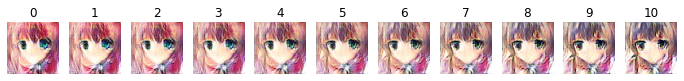

In [ ]:

z_interlop = linear_interpolation(noise_input[24],noise_input[36],11)

variations = G_model.predict(z_interlop)

plt.figure(figsize=(12,14))
for i in range(amount_of_latent_space_steps):
  plt.subplot(1, amount_of_latent_space_steps, 1 + i)
  plt.axis('off')
  plt.imshow(variations[i,:,:,:])
  plt.title(i)
plt.show()

- Extend the last process to morph between 3 different images `I1`, `I2`, `I3`:
 - Generate a morphing sequence from `I1` to `I2`, from `I2` to `I3`, and from `I3` back to `I1`.

In [ ]:
def plot_images(images, amount_of_images):
  plt.figure(figsize=(12,14))
  for i in range(amount_of_images):
    plt.subplot(1, amount_of_images, 1 + i)
    plt.axis('off')
    plt.imshow(images[i,:,:,:])
    plt.title(i)
plt.show()

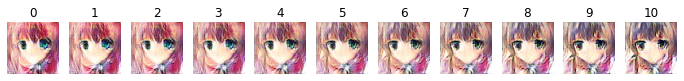

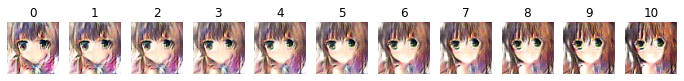

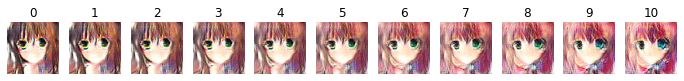

In [ ]:
###########################
###  your code here...  ###
###########################
amount_of_steps = 11
I1 = noise_input[24]
I2 = noise_input[36]
I3 = noise_input[8]
z_interlop1 = linear_interpolation(I1,I2,amount_of_steps)
z_interlop2 = linear_interpolation(I2,I3,amount_of_steps)
z_interlop3 = linear_interpolation(I3,I1,amount_of_steps)

variation1 = G_model.predict(z_interlop1)
variation2 = G_model.predict(z_interlop2)
variation3 = G_model.predict(z_interlop3)

plot_images(variation1, amount_of_steps)
plot_images(variation2, amount_of_steps)
plot_images(variation3, amount_of_steps)


- Finally, if you wish, you can generate an animated GIF of your generated sequence:

In [ ]:
anim_file = 'animation.gif'

import imageio

with imageio.get_writer(anim_file, mode='I') as writer:
  for pic in variation1:
    pic = pic*255
    pic = pic.astype(np.uint8)
    writer.append_data(pic)
  for pic in variation2:
    pic = pic*255
    pic = pic.astype(np.uint8)
    writer.append_data(pic)
  for pic in variation3:
    pic = pic*255
    pic = pic.astype(np.uint8)
    writer.append_data(pic)
    # loop over the images you want to add to the animated GIF file
    # use: writer.append_data(your_image)
    # where your_image should be np.uint8 format, with values from 0-255.
  

***
## Good Luck!